In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_dir = '/content/drive/MyDrive/Dataset Dr.Fruithy/Manggo'

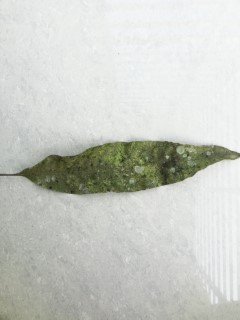

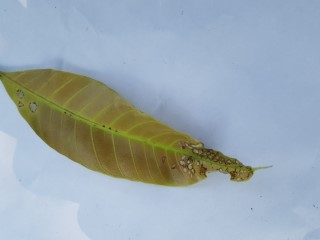

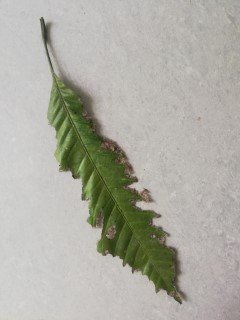

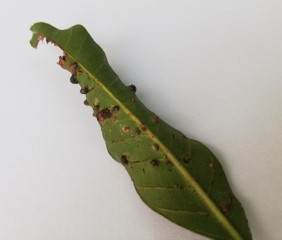

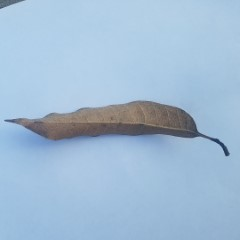

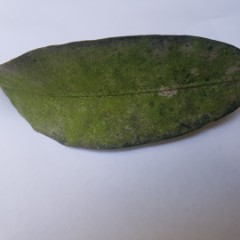

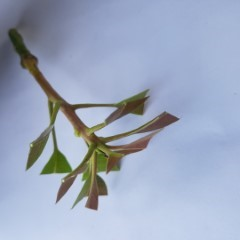

In [ ]:
from IPython.display import display, Image, HTML

# melist semua image direktori
folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

# Menampilkan 1 sampel dari setiap folder disease mangga
for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if images:
        sample_image = images[0]
        image_path = os.path.join(folder_path, sample_image)
        display(HTML(f'<h3>{folder}</h3>'))
        display(Image(filename=image_path, width=200))

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (240, 320),
    batch_size = 32)

Found 3500 files belonging to 7 classes.


In [ ]:
dataset.class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Powdery Mildew',
 'Sooty Mould']

In [ ]:
dataset_size = len(dataset)
print(dataset_size)

110


In [ ]:
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # menegatur
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
# Example usage:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [ ]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

88
11
11


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(240,320),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

In [ ]:
from tensorflow.keras.optimizers import Adam
resize_and_rescale,
data_augmentation,

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(240, 320, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Flatten layer
  tf.keras.layers.Flatten(),

  # Add fully connected layers with dropout and regularization
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(8, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 240, 320, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 240, 320, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 120, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 160, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 120, 160, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 60, 80, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 80, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 80, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 40, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 307200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      78,643,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,049,992 (301.55 MB)

 Trainable params: 79,049,096 (301.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(train_ds, epochs = 15, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 609ms/step - accuracy: 0.5510 - loss: 3.8277 - val_accuracy: 0.1847 - val_loss: 13.6455
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8523 - loss: 1.2134 - val_accuracy: 0.6364 - val_loss: 1.9718
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.8987 - loss: 1.0439 - val_accuracy: 0.7642 - val_loss: 2.0397
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.9273 - loss: 0.9159 - val_accuracy: 0.9375 - val_loss: 0.8246
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.9435 - loss: 0.8140 - val_accuracy: 0.8722 - val_loss: 1.0123
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9563 - loss: 0.7755 - val_accuracy: 0.9716 - val_loss: 0.6878
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9567 - loss: 0.7630 - val_accuracy: 0.9915 - val_loss: 0.6065
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.9610 - loss: 0.7210 - val_ac

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 15
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names = dataset.class_names
print(class_names)

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import shutil

h5_model_path = "/content/drive/MyDrive/Dataset Dr.Fruithy/Saved Model/Manggo/h5/manggo_model.h5"
model.save(h5_model_path)

print(f"Model berhasil disimpan sebagai {h5_model_path}")

In [ ]:
from IPython.display import FileLink

print("Klik link di bawah untuk mendownload file:")
display(FileLink(h5_model_path))